In [1]:
from sklearn.base import BaseEstimator, TransformerMixin

class AddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, where_x, functions=None):
        self.functions = functions
        self.where_x = where_x
    def fit(self, X, y):
        return self
    def transform(self, X):
        # .T to iterate over the cols of the array
        # vstack to stack vertically row by row
        # then .T to go back to the initial shape
        # not taking the intercept (index 0)
        #if self.intercept_exist:
        #    start = 1
        #    x_ = X[:,start:]
        #else:
        #    start = 0
        #    x_ = X
        x_ = X[:, [self.where_x]].copy()
        self.funcs_applied = ["{}".format(func.__name__) for func in self.functions]
        cols =  np.hstack([func(x_) for func in self.functions])
        return np.hstack([X, cols])

In [3]:
from sklearn.pipeline import Pipeline

In [4]:
class BetterPipeline(Pipeline):
    """ Since pipeline.transform does work only when all estimators are transformers of the data,
    and mostly i'm fitting a model as last estimator, i prefer creating a just_transform method for that"""
    def just_transforms(self, X):
        """Applies all transforms to the data, without applying last 
           estimator.

        Parameters
        ----------
        X : iterable
            Data to predict on. Must fulfill input requirements of first step of
            the pipeline.
        """
        Xt = X
        for name, transform in self.steps[:-1]:
            Xt = transform.transform(Xt)
        return Xt

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

import numpy as np

In [13]:
x = np.linspace(0, 2*np.pi, 100)
y = np.random.normal(np.sin(x), scale=0.4)

In [15]:
funcs = [np.sin, np.cos, np.exp]

In [ ]:
x_after_feature_engineering = pipeline.just_transforms(x[:, np.newaxis])

In [17]:
# scenario 1
scaling_and_gradient_descent = BetterPipeline([
    ('adding_features', AddFeatures(where_x=0)),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('scaler', StandardScaler()),
    ('linear_reg', SGDRegressor(fit_intercept=False))
])

# scenario 2
scaling_and_OLS = BetterPipeline([
    ('adding_features', AddFeatures(where_x=0)),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('scaler', StandardScaler()),
    ('linear_reg', SGDRegressor(fit_intercept=False))
])

# scenario 3
OLS = BetterPipeline([
    ('adding_features', AddFeatures(where_x=0)),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('linear_reg', LinearRegression(fit_intercept=False))
])

# scenario 3
gradient_descent = BetterPipeline([
    ('adding_features', AddFeatures(where_x=0)),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('linear_reg', LinearRegression(fit_intercept=False))
])




pipeline.set_params(adding_features__functions=funcs)
pipeline.fit(x[:, np.newaxis], y)

NameError: name 'pipeline' is not defined

In [107]:
import matplotlib.pyplot as plt

# Tuning hyperparameters or data processing steps

Ok so, so far we fitted a **model on a train** set and later computed an **MSE** on both the train, and **test** set to assess whether an **overfit** would have occured. And that was the case. 

So we decided to use another model than the base linear regression one. We used **Lasso**.<br>
Lasso does have a **slightly difference risk function definition**: to the sum of squared errors risk function derived from OLS, Lasso **adds an additional penalty to constraint the amplitude (1-norm) of the estimated $\beta$s** while still trying to meet **minimization** of the sum of squared errors.

OLS estimator, being the **best linear unbiased estimator**, **adding an additional constraint** for the $\beta$s will **add bias to those estimations** of the $\beta$s (what we call **estimation bias**) which **adds up to** the bias the model may already have (**from assumptions, ommited variables or interactions** or other), what we call **model bias** (the difference from our best-fitting linear approximation and the true function).

Why doing so ? In an attempt to **decrease variances around the estimates**, hence the **variance of the model itself**, and get a **lower MSE eventually**.

The penality coefficient $lambda$ (or $alpha$ depending on the litterature or the API) is what we call an **hyperparameter**: we fix it **prior** to the **actual learning process**.<br> Here this hyperparameter is a called a regularization hyperparameter.<br>
In Scikit-Learn, they are passed as arguments to the constructor of the estimator classes.<br>
So **which** $lambda$ to use so to get the most reduction in a MSE compared to our initial linear regression model ? <br>
and by the **way which MSE** are we talking about ? 

Of course we are not going to control setting up our hyperparameters based on the MSE for the training set: that would lead exactly to the very first situation where we **shaped our mind, our representation of our data and our modelisation out of it to solely satisfy ourself on what we know, rather than what we don't yet** loosing all the predictive ability of our model, and getting back to the overfitting issue.

# Cross validation to the rescourse !

Cross-validation is the simplest method for estimating the **expected prediction error** i.e. the expected extra-sample error for when we fit a model to a training set and evaluate its predictions on **unseen data**.

So we will check the MSE on the test set, in a bid to reduce it.

But if you were to **tune** hyperparams or data preparation steps while **checking variations of MSE on test towards a minimization of it**, well, we would still somehow use a metric, a quantitative measure **we shouldn't be aware of**, as it is supposed to be the mean squared errors of the model on **unseen data**.<br>
To give another example: it is as if you had to forecast whether or not to buy vegetables while not having access to the inside of the fridge. If you can **weight** the fridge itself, you might not know how many vegetables are left among all the food, but at least you have a taste of how likely the fridge is empty, considering the vegetables are the heaviest, hence you modify your behavior respectively.

This has a name: it is called **data leakage**.

You would have to actually split the whole data in 3 sets: **train**, **test** and **validation**, so to keep at least one set of data only for estimating the expected prediction error of the final model.<br>
You train the model with $lambda1$ on the training set, you monitor the MSE on the test set, you update $lambda$ to the new value, and once you found a satisfying minimum of the MSE, you can retrain on the whole available data (train+test) and finally evaluate the final model using the hold-out validation test.

In [969]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [207]:
funcs = [np.sin, np.cos, np.exp]

In [311]:
# scenario 1
scaling_and_gradient_descent = BetterPipeline([
    ('adding_features', AddFeatures(where_x=0, functions=funcs)),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('scaler', StandardScaler()),
    ('linear_reg', SGDRegressor(fit_intercept=False))
])

# scenario 2
scaling_and_OLS = BetterPipeline([
    ('adding_features', AddFeatures(where_x=0, functions=funcs)),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('scaler', StandardScaler()),
    ('linear_reg', LinearRegression(fit_intercept=False))
])

In [312]:
scaling_and_gradient_descent.fit(x2, y)
scaling_and_OLS.fit(x2, y)

BetterPipeline(steps=[('adding_features',
                       AddFeatures(functions=[<ufunc 'sin'>, <ufunc 'cos'>,
                                              <ufunc 'exp'>],
                                   where_x=0)),
                      ('poly', PolynomialFeatures(interaction_only=True)),
                      ('scaler', StandardScaler()),
                      ('linear_reg', LinearRegression(fit_intercept=False))])

In [315]:
x_transformed = scaling_and_gradient_descent.just_transforms(x2)

------

##### pour Denis

In [308]:
lasso = Lasso(alpha=0.00000001, tol=1)
lasso.fit(x_transformed, y)

Lasso(alpha=1e-08, tol=1)

In [319]:
import seaborn as sns

[Text(0.5, 1.0, 'coefficients obtained using Gradient Descent')]

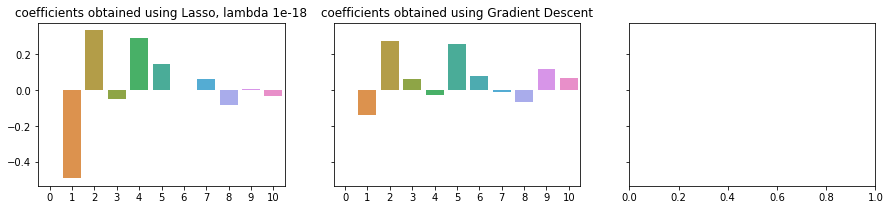

In [328]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3), sharey=True)
sns.barplot(x=list(range(11)), y=lasso.coef_, ax=axes[0]).set(
    title="coefficients obtained using Lasso, lambda 1e-18")
sns.barplot(x=list(range(11)), y=scaling_and_gradient_descent.named_steps.linear_reg.coef_, 
            ax=axes[1]).set(title="coefficients obtained using Gradient Descent")
#sns.barplot(x=list(range(11)), y=scaling_and_OLS.named_steps.linear_reg.coef_, 
#            ax=axes[2]).set(title="coefficients obtained using OLS")

-----

In [330]:
from sklearn.model_selection import train_test_split

In [343]:
X_train, X_test, y_train, y_test = train_test_split(x_transformed, y, train_size=0.70)

In [392]:
lasso_models, alphas, MSE_train, MSE_test = [], [], [], []
for alpha in np.linspace(0.0000001,0.25,100):
    lasso_model = Lasso(alpha=alpha, tol=0.5)
    lasso_model.fit(X_train, y_train)
    mse_train = mean_squared_error( lasso_model.predict(X_train), y_train )
    mse_test  = mean_squared_error( lasso_model.predict(X_test), y_test )
    alphas.append(alpha); MSE_train.append(mse_train); MSE_test.append(mse_test)

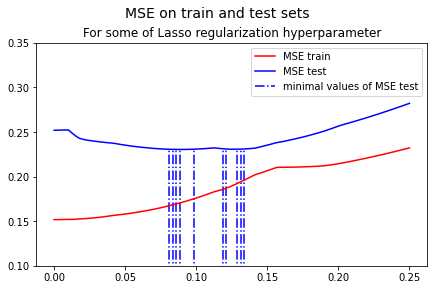

In [419]:
plt.plot(alphas, MSE_train, color='r', label="MSE train")
plt.plot(alphas, MSE_test,  color='b', label="MSE test")
plt.ylim(0.10, 0.35)
plt.vlines(x=np.array(alphas)[np.argsort(MSE_test)[:20:2]], ymin=0, ymax=min(MSE_test), color='b', linestyles='-.', label="minimal values of MSE test")
plt.legend()
plt.suptitle("MSE on train and test sets", fontsize=14)
plt.title("For some of Lasso regularization hyperparameter")
plt.tight_layout(pad=0.6)

# K-Fold cross validation

Splitting data again and again in an attempt to put Chinese walls in your ML workflow, lead to another issue: what if you **don't have much** data? it is likely your MSE(test) on a **few dozen points could be overly optimistic**, what if by chance you got the right test points to have a sweet MSE that suit your needs for a certain model ? 

K-Fold cross validation is an attempt to use every data points at least in the testing part.<br>
It is still cross-validation, but this time you split your dataset in **K** aproximately equally sized **folds**.<br>
Then you **train the model on K-1** folds and test it on the **remaining one**. You do it **K times** (each time tested for **each remaining test fold**). Yes, you end up with **K number of MSE(test-fold)**.
- On a train-test design, the average of the MSE is still a good estimate for the expected prediction error of the model.
- On a train-test-validation one, you still have more confidence that no data points were left while computing the MSE "on the test".

Let's do a k-fold cross validation

In [70]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer

In [65]:
cross_val_score(LinearRegression(), x2, y, scoring="r2")

array([-0.95596911, -2.89048347,  0.18178379, -5.47694298, -2.31706554])

scoring takes a scoring parameter (greater is better), hence is used the R2 is an appropriate choice, 
we could have taken the negation of the MSE too.

In [66]:
cross_val_score(LinearRegression(), x2, y, scoring=make_scorer(mean_squared_error))

array([0.3279406 , 0.45555535, 0.25739018, 1.03002024, 1.27365498])

In [68]:
- cross_val_score(LinearRegression(), x2, y, scoring="neg_mean_squared_error")

array([0.3279406 , 0.45555535, 0.25739018, 1.03002024, 1.27365498])

- 5 folds
- 5 model training
- 5 test sets
- 5 MSE

Wow ? difference are so important from one test set to another ! why is so ?
When the MSE is high, the R2 is low, sometimes negative ? worse than a simple dummy model (H0 hypthesis) using the average. Why is so ?

In [83]:
folding = KFold(5)

In [84]:
folding.split(x2, y)

<generator object _BaseKFold.split at 0x12b2c5430>

Wow ! a generator object !

In [104]:
generator = folding.split(x2, y)

In [105]:
next(generator) # training indices, testing indices

(array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
        88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]))

In [184]:
def cross_val_visualize(X, y, cv=5, shuffle=False):
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error
    from sklearn.linear_model import LinearRegression

    new_fig, axes =  plt.subplots(figsize=(cv*3, 3), ncols=cv, sharey=True)
    regressions, MSE = [], []
    folds = KFold(cv, shuffle=shuffle).split(X, y)
    
    for i_, (train_indices, test_indices) in enumerate(folds):
        # train on each 4 folds subset
        lm = LinearRegression()
        lm.fit( X[train_indices], y[train_indices])
        # predict on each test fold
        y_pred = lm.predict(X[test_indices])
        # compute MSE for those test fold
        mse = mean_squared_error(lm.predict(X[test_indices]), y[test_indices])
        # plot the training points, test points, and the fit for the fold
        axes[i_].scatter( X[train_indices], y[train_indices], color='r')
        axes[i_].scatter( X[test_indices], y[test_indices], color='g')
        axes[i_].plot( X, lm.predict(X), color='black' )
        # save the results | save the models
        MSE.append(mse); regressions.append(lm)
    return MSE

[0.32794060000061515,
 0.45555535076735226,
 0.2573901788986118,
 1.0300202445239781,
 1.273654982470511]

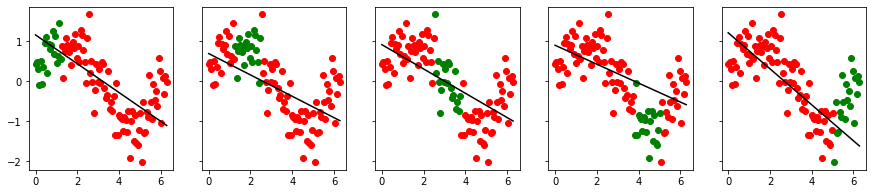

In [185]:
cross_val_visualize(x2, y)

[0.24514477688923542, 0.38705639490105015, 0.6231891770127047]

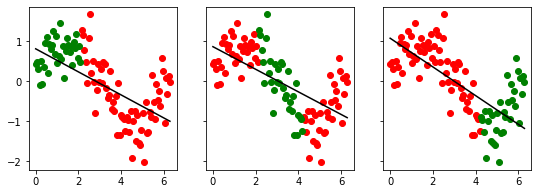

In [186]:
cross_val_visualize(x2, y, 3)

[0.3711358856524268,
 0.3821283100103246,
 0.5107607283792079,
 0.4372335783422797,
 0.37844005566106576]

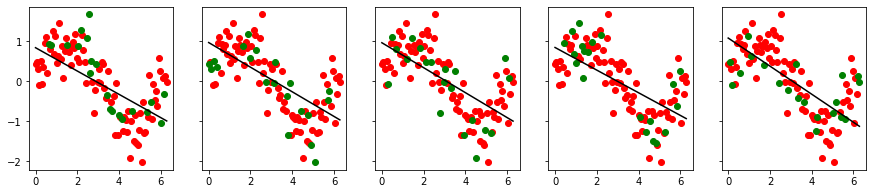

In [202]:
cross_val_visualize(x2, y, shuffle=True)

Much more homogeneous results !

Yes, the misleading results here are drawn by the fact the train and test set were not taken randomly

# Bringing that up together: GridSearch

If you followed the previous steps, here is what is going to be the overall scheme of the hyperparameter tuner (you :p)

1. Splitting the whole dataset in **train - validation** (e.g. of ratios: 0.80 / 0.20).
2. Leave the validation set for a while, it will be use **at the end** for an estimation of the expected prediction error of the **final model**.
3. Choose a **set of hyperparameters values** to try, if you have 2 hyperparameters $hyper1$ and $hyper2$, one would do want to try all combinations of the values taken by $(hyper1, hyper2)$
4. Split the **training set** in **train - set**, or better, split into $k$ sets of $k-fold$ partitions.
5. Select a model (or a set of models) and a **combination of its corresponding** hyperparameter $(hyper1, hyper2)$
6. Train it $k$ times (one for each cross validation) and average the **MSE results**.
7. Pick up the model which performed the best, using the average MSE with the best combination of hyperparameters' values.
8. **Retrain** it on the whole initial training set (as it is the model you elected, you no longer need to use this/these intermediates test-sets.
9. Evaluate the performance using the held-out validation set.

Actually, this is a pattern often used and sklearn provide a function for this (rather that implementing by hand and using nested for loops to find inside the hyperparameter space...)

In [939]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import Lasso, Ridge

In [960]:
gs = GridSearchCV(
    estimator=Lasso(tol=0.5),
    param_grid={ "alpha" : np.linspace(0.000001, 0.25, 100) },
    scoring=make_scorer(mean_squared_error),
    cv=KFold(5, shuffle=True)
)

In [961]:
gs.fit(x_transformed, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Lasso(tol=0.5),
             param_grid={'alpha': array([1.00000000e-06, 2.52624242e-03, 5.05148485e-03, 7.57672727e-03,
       1.01019697e-02, 1.26272121e-02, 1.51524545e-02, 1.76776970e-02,
       2.02029394e-02, 2.27281818e-02, 2.52534242e-02, 2.77786667e-02,
       3.03039091e-02, 3.28291515e-02, 3.53543939e-02, 3.787963...
       1.91919424e-01, 1.94444667e-01, 1.96969909e-01, 1.99495152e-01,
       2.02020394e-01, 2.04545636e-01, 2.07070879e-01, 2.09596121e-01,
       2.12121364e-01, 2.14646606e-01, 2.17171848e-01, 2.19697091e-01,
       2.22222333e-01, 2.24747576e-01, 2.27272818e-01, 2.29798061e-01,
       2.32323303e-01, 2.34848545e-01, 2.37373788e-01, 2.39899030e-01,
       2.42424273e-01, 2.44949515e-01, 2.47474758e-01, 2.50000000e-01])},
             scoring=make_scorer(mean_squared_error))

In [962]:
gs.best_estimator_, gs.best_params_

(Lasso(alpha=0.25, tol=0.5), {'alpha': 0.25})

In [963]:
df_grid = pd.DataFrame(gs.cv_results_)
params = df_grid.params.apply(pd.Series)
df_grid = pd.concat([params, df_grid], axis=1)

/Users/lucbertin/.pyenv/versions/3.8.4/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


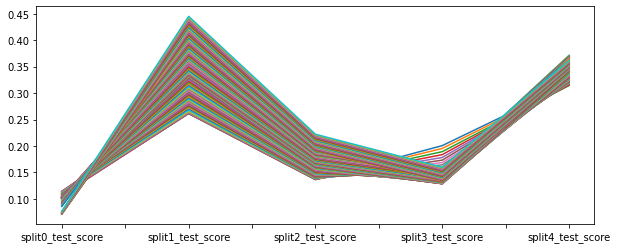

In [964]:
splits_measures = [col for col in df_grid if col.startswith("split")] 
ax = df_grid.set_index(["alpha"])[splits_measures].T.plot(kind="line", figsize=(10,4))
ax.get_legend().remove()
#plt.xticks(rotation=90)

In [965]:
from sklearn.svm import SVR
param_grid = {
    'C'     : np.linspace(4, 15, 20),
    'gamma' : np.linspace(0.001, 0.25, 20)
}
gs = GridSearchCV(estimator=SVR(), param_grid=param_grid, cv=3, scoring=make_scorer(mean_squared_error))
gs.fit(x_transformed, y)

GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': array([ 4.        ,  4.57894737,  5.15789474,  5.73684211,  6.31578947,
        6.89473684,  7.47368421,  8.05263158,  8.63157895,  9.21052632,
        9.78947368, 10.36842105, 10.94736842, 11.52631579, 12.10526316,
       12.68421053, 13.26315789, 13.84210526, 14.42105263, 15.        ]),
                         'gamma': array([0.001     , 0.01410526, 0.02721053, 0.04031579, 0.05342105,
       0.06652632, 0.07963158, 0.09273684, 0.10584211, 0.11894737,
       0.13205263, 0.14515789, 0.15826316, 0.17136842, 0.18447368,
       0.19757895, 0.21068421, 0.22378947, 0.23689474, 0.25      ])},
             scoring=make_scorer(mean_squared_error))

In [966]:
df_grid = show_params_as_df(gs, ['C', 'gamma'])
df_grid

,C,gamma,split0_test_score,split1_test_score,split2_test_score
0,4.0,0.001000,0.611261,0.261456,0.596544
1,4.0,0.014105,0.173154,0.232858,0.203825
2,4.0,0.027211,0.138710,0.243590,0.192375
3,4.0,0.040316,0.141636,0.228891,0.220583
4,4.0,0.053421,0.144939,0.238139,0.266923
...,...,...,...,...,...
395,15.0,0.197579,0.404329,0.256850,0.741546
396,15.0,0.210684,0.422260,0.257666,0.784791
397,15.0,0.223789,0.441236,0.257839,0.856519
398,15.0,0.236895,0.461408,0.259146,0.911760


In [967]:
pivot = df_grid.pivot_table(index='C', columns='gamma').stack(level=1).apply(np.mean, axis=1)

<AxesSubplot:xlabel='gamma', ylabel='C'>

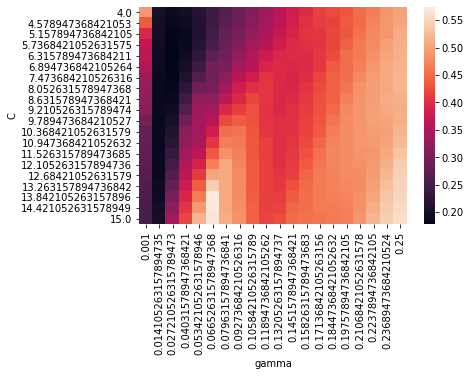

In [968]:
sns.heatmap(pivot.unstack())

# Enhanced GridSearch over pipeline params ! :O

> Parameters of the estimators in the pipeline can be accessed using the **estimator__parameter** syntax. **Individual steps may also be replaced** as parameters, and **non-final steps may be ignored** by setting them to **'passthrough'**

Let's take 2 scenarios set (each defined as a pipeline), the possibilities are endless by combining GridSearch with Pipelines:

In [925]:
# Using GridSearch
pipeline = BetterPipeline([
    ('adding_features', AddFeatures(where_x=0)),
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('linear_reg', LinearRegression())
])

In [926]:
def identity(x):
    return x

In [927]:
param_grid = dict(
    adding_features__functions = [[identity], [identity, np.sin, np.exp, np.cos], [np.sin], [np.exp]],
    poly__degree = [1,2,3]
)

In [928]:
gs = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=KFold(3, shuffle=True)
)
gs.fit(x2_more_points, y_more_points)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=BetterPipeline(steps=[('adding_features',
                                              AddFeatures(where_x=0)),
                                             ('poly', PolynomialFeatures()),
                                             ('scaler', StandardScaler()),
                                             ('linear_reg',
                                              LinearRegression())]),
             param_grid={'adding_features__functions': [[<function identity at 0x140f5a670>],
                                                        [<function identity at 0x140f5a670>,
                                                         <ufunc 'sin'>,
                                                         <ufunc 'exp'>,
                                                         <ufunc 'cos'>],
                                                        [<ufunc 'sin'>],
                                      

In [929]:
df_grid = pd.DataFrame(gs.cv_results_)

In [930]:
gs.best_params_

{'adding_features__functions': [<ufunc 'sin'>], 'poly__degree': 1}

In [931]:
df_grid.rename(columns = { 'mean_test_score': 'neg_mean_test_score' }, inplace=True)

In [932]:
df_grid.sort_values('neg_mean_test_score', ascending=False)[:3] # 3 best performing models

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_adding_features__functions,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,neg_mean_test_score,std_test_score,rank_test_score
6,0.002088,0.000064,0.000738,0.000011,[<ufunc 'sin'>],1,{'adding_features__functions': [<ufunc 'sin'>]...,-0.040405,-0.040612,-0.047605,-0.042874,0.003346,1
3,0.001898,0.000028,0.000752,0.000097,"[<function identity at 0x140f5a670>, <ufunc 's...",1,{'adding_features__functions': [<function iden...,-0.040724,-0.040994,-0.047577,-0.043098,0.003169,2
7,0.002207,0.000123,0.000740,0.000008,[<ufunc 'sin'>],2,{'adding_features__functions': [<ufunc 'sin'>]...,-0.040817,-0.040947,-0.047645,-0.043137,0.003189,3


In [933]:
estimator =  gs.best_estimator_

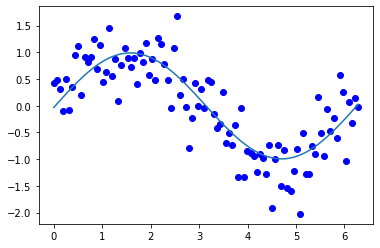

In [934]:
plt.scatter(x, y, color='blue')
plt.plot(x, estimator.predict(x))

We find back the sin ! :D

In [935]:
param_grid_lasso = { 
    **param_grid,
    "linear_reg" : [Lasso(tol=0.5)],
    "linear_reg__alpha" : np.linspace(0.00000001, 1, 50)
}

In [936]:
gs = GridSearchCV(pipeline, param_grid=param_grid_lasso, 
                  scoring="neg_mean_squared_error", cv=KFold(3, shuffle=True))
gs.fit(x2_more_points, y_more_points)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=BetterPipeline(steps=[('adding_features',
                                              AddFeatures(where_x=0)),
                                             ('poly', PolynomialFeatures()),
                                             ('scaler', StandardScaler()),
                                             ('linear_reg',
                                              LinearRegression())]),
             param_grid={'adding_features__functions': [[<function identity at 0x140f5a670>],
                                                        [<function identity at 0x140f5a670>,
                                                         <ufunc '...
       5.71428576e-01, 5.91836739e-01, 6.12244902e-01, 6.32653065e-01,
       6.53061228e-01, 6.73469391e-01, 6.93877554e-01, 7.14285717e-01,
       7.34693880e-01, 7.55102043e-01, 7.75510206e-01, 7.95918369e-01,
       8.16326532e-01, 8.36734696e-01, 8.57142

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_adding_features__functions,param_linear_reg,param_linear_reg__alpha,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,neg_mean_test_score,std_test_score,rank_test_score
152,0.003711,0.000276,0.001259,0.000031,"[<function identity at 0x140f5a670>, <ufunc 's...","Lasso(alpha=1e-08, tol=0.5)",1e-08,3,{'adding_features__functions': [<function iden...,-0.049015,-0.042963,-0.042469,-0.044815,0.002976,1
151,0.002369,0.000276,0.000835,0.000136,"[<function identity at 0x140f5a670>, <ufunc 's...","Lasso(alpha=1e-08, tol=0.5)",1e-08,2,{'adding_features__functions': [<function iden...,-0.053484,-0.045553,-0.044973,-0.048004,0.003883,2
155,0.003686,0.000721,0.001281,0.000088,"[<function identity at 0x140f5a670>, <ufunc 's...","Lasso(alpha=1e-08, tol=0.5)",0.0204082,3,{'adding_features__functions': [<function iden...,-0.055127,-0.046499,-0.045358,-0.048995,0.004361,3


BetterPipeline(steps=[('adding_features',
                       AddFeatures(functions=[<function identity at 0x140f5a670>,
                                              <ufunc 'sin'>, <ufunc 'exp'>,
                                              <ufunc 'cos'>],
                                   where_x=0)),
                      ('poly', PolynomialFeatures(degree=3)),
                      ('scaler', StandardScaler()),
                      ('linear_reg', Lasso(alpha=1e-08, tol=0.5))])

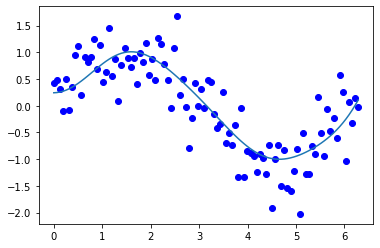

In [938]:
df_grid = pd.DataFrame(gs.cv_results_)
df_grid.rename(columns = { 'mean_test_score': 'neg_mean_test_score' }, inplace=True)
display(df_grid.sort_values('neg_mean_test_score', ascending=False)[:3]) # 3 best performing models
estimator =  gs.best_estimator_
display(estimator)
plt.scatter(x, y, color='blue')
plt.plot(x, estimator.predict(x))

Lasso might have canceled out some params i guess (at least on the 3rd model)